In [13]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from src.data_tools.preprocessor import load_czech_media_data
from src.models.predictor import TrollPredictor

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

In [2]:
MODEL_DIR = Path('../checkpoints')
DATA_DIR = Path('../data')

# Initialize predictor with best model
predictor = TrollPredictor(
    model_path=str(MODEL_DIR / 'best_model.pt'),
    comments_per_user=5,
    max_length=64
)

In [3]:
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading files: 100%|██████████████████████████████████████████████████████| 124/124 [00:03<00:00, 31.82it/s]


Loaded 846098 comments from 66607 unique authors


In [4]:
# Display data info
print("\nDataset columns:", czech_comments.columns.tolist())
print("\nSample of comments:")
print(czech_comments[['text', 'author', 'sentiment']].head())


Dataset columns: ['text', 'author', 'timestamp', 'article_title', 'url', 'article_id', 'sentiment']

Sample of comments:
                                                text        author   sentiment
0                        Umí i něco jiného než lhát?   Jiří Mraček    Negative
1  Nezávislost na Rusku je lež jako věž z Ruska b...  Fiala Václav    Negative
2  Vsak jak jinak. Pořád si stěžovali, že se musí...   Jana Krejci     Neutral
3  Jedna reforma školství stíhá druhou, hlavně ab...   Jiří Flusek     Neutral
4  Frantisek LuftNaštěstí to vychází z logiky int...   Honza Novak  Ambivalent


In [5]:
# Save processed data
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)
czech_comments.to_parquet(PROCESSED_DIR / 'czech_media_comments.parquet')

In [4]:
# Make Predictions
results = []
for idx, group in tqdm(czech_comments.groupby('author')):
    texts = group['text'].tolist()
    
    # Get prediction
    pred = predictor.predict_batch(texts)
    
    # Store results
    results.append({
        'author': idx,
        'n_comments': len(texts),
        'prediction': pred['prediction'],
        'confidence': pred['confidence'],
        'troll_probability': pred['probabilities'][1]
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████| 66607/66607 [06:10<00:00, 179.54it/s]


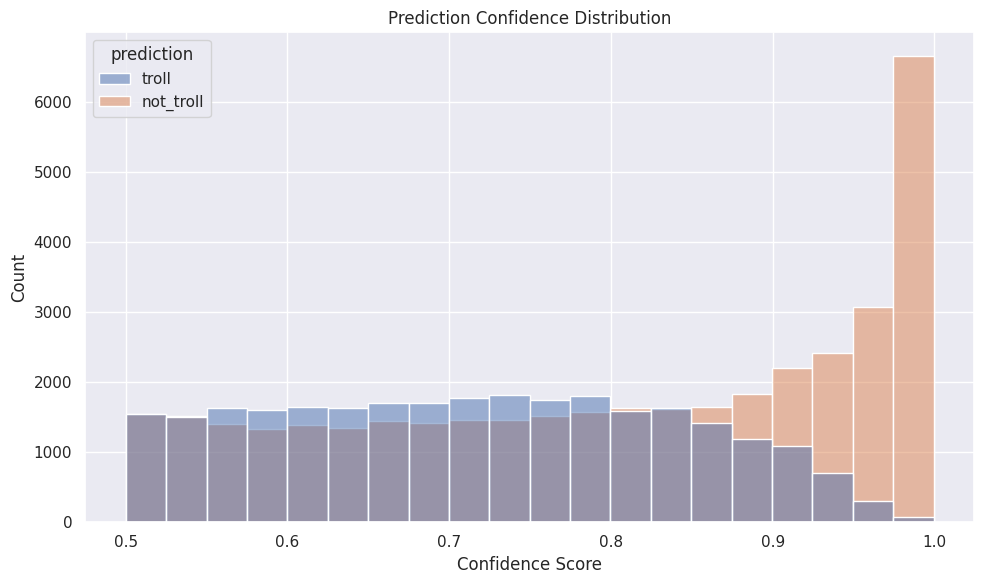


=== High Confidence Troll Predictions ===

Found 2154 high confidence troll predictions

--- High Confidence Prediction 1 ---
Author: Luděk Tikovský
Confidence: 0.995
Troll Probability: 0.995

Sample comments:
--------------------------------------------------------------------------------
Donald Trump MAKE EU GREAT AGAIN
----------------------------------------

--- High Confidence Prediction 2 ---
Author: Jiří Pechar
Confidence: 0.995
Troll Probability: 0.995

Sample comments:
--------------------------------------------------------------------------------
Trump Makes Russia Great Again.
----------------------------------------

--- High Confidence Prediction 3 ---
Author: Helena Mašková
Confidence: 0.994
Troll Probability: 0.994

Sample comments:
--------------------------------------------------------------------------------
Suicide by cop...
----------------------------------------

=== Uncertain Predictions (Medium Confidence) ===

Found 6692 medium confidence predictions

--- M

In [19]:
# Cell: Analyze predictions by confidence levels
# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(
    data=results_df, 
    x='confidence', 
    hue='prediction', 
    bins=20
)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print analysis of high confidence predictions
print("\n=== High Confidence Troll Predictions ===")
high_conf_trolls = results_df[
    (results_df['prediction'] == 'troll') & 
    (results_df['confidence'] >= 0.9)
].sort_values('confidence', ascending=False)

if len(high_conf_trolls) > 0:
    print(f"\nFound {len(high_conf_trolls)} high confidence troll predictions")
    for i, (_, row) in enumerate(high_conf_trolls.head(3).iterrows(), 1):
        print(f"\n--- High Confidence Prediction {i} ---")
        print(f"Author: {row['author']}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Troll Probability: {row['troll_probability']:.3f}")
        print("\nSample comments:")
        print("-" * 80)
        # Get comments for this author
        author_comments = czech_comments[czech_comments['author'] == row['author']]['text'].head(2)
        for comment in author_comments:
            print(comment[:200] + "..." if len(comment) > 200 else comment)
            print("-" * 40)
else:
    print("No high confidence troll predictions found")

# Print analysis of uncertain predictions
print("\n=== Uncertain Predictions (Medium Confidence) ===")
medium_conf = results_df[
    (results_df['confidence'] >= 0.6) & 
    (results_df['confidence'] < 0.7) &
    (results_df['prediction'] == 'troll')
].sort_values('confidence')

if len(medium_conf) > 0:
    print(f"\nFound {len(medium_conf)} medium confidence predictions")
    for i, (_, row) in enumerate(medium_conf.head(3).iterrows(), 1):
        print(f"\n--- Medium Confidence Prediction {i} ---")
        print(f"Author: {row['author']}")
        print(f"Prediction: {row['prediction']}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Troll Probability: {row['troll_probability']:.3f}")
        print("\nSample comments:")
        print("-" * 80)
        # Get comments for this author
        author_comments = czech_comments[czech_comments['author'] == row['author']]['text'].head(2)
        for comment in author_comments:
            print(comment[:200] + "..." if len(comment) > 200 else comment)
            print("-" * 40)
else:
    print("No medium confidence predictions found")

# Save detailed results
output_dir = Path('../output')
output_dir.mkdir(exist_ok=True)
high_conf_trolls.to_csv(output_dir / 'high_confidence_predictions.csv', index=False)
medium_conf.to_csv(output_dir / 'medium_confidence_predictions.csv', index=False)